# Kalman Filter for LUNA Modelling

## Explanation

In order to predict drop out, we can start by estimating an underlying latent variable ("intent to drop out"). My Understanding is, that this is mostly measured by the PANNP (etc) items. We can map these items into a latent space using the loadings found via CFA. With these, we can then measure and predict the "intent to drop out".

### Assumption: The loadings do infact measure this latent factor! We need to check this!

## Usage

See below for an example. The model at this point only runs on a per-person basis. 

## Next steps

1. Get this running on real data
2. Deploy
3. We can probably extend this into a type of multi-level model, by passing all students in a class, with a given covariance structure.


In [224]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [225]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0
        self.predictions = np.array([])

    def predict(self, u = 0):
        self.x = self.F @ self.x + self.B + u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x, self.P

    def update(self, z):
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P @ self.H.T
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + K @ self.R @ K.T

    def forward(self, observations):
        # Runs the forward algorithm based on observations
        self.predictions_state = []
        self.predictions_obs = []
        self.predictions_cov = []

        for z in observations.T:
            z = z.reshape(3,1)
            self.predictions_obs.append(H @ self.predict()[0])
            self.predictions_state.append(self.predict()[0])
            self.predictions_cov.append(self.predict()[1])
            self.update(z)
        
        return self.predictions_state, self.predictions_cov, self.predictions_obs
    
    def rts_smoother(self, predictions_state, predictions_cov):
        predictions_state = np.array(predictions_state)
        predictions_cov = np.array(predictions_cov)
        n, dim_x, _ = predictions_state.shape   
        # RTS smoother gain
        K = np.zeros((n,dim_x,dim_x))
        x_smooth = np.zeros((n,dim_x,1))
        P_smooth = np.zeros((n,dim_x,dim_x))

        x_smooth[-1] = predictions_state[-1]
        P_smooth[-1] = predictions_cov[-1]

        for k in range(n-2,-1,-1):
            P_pred = np.dot(np.dot(self.F, predictions_cov[k]), self.F.T) + self.Q

            K[k]  = np.dot(np.dot(predictions_cov[k], self.F.T), np.linalg.inv(P_pred))
            x_smooth[k] = predictions_state[k] + np.dot(K[k], x_smooth[k+1] - np.dot(self.F, predictions_state[k]))
            P_smooth[k] = predictions_cov[k] + np.dot(np.dot(K[k], P_smooth[k+1] - P_pred), K[k].T)
        
        return x_smooth, P_smooth, K

## Example Usage

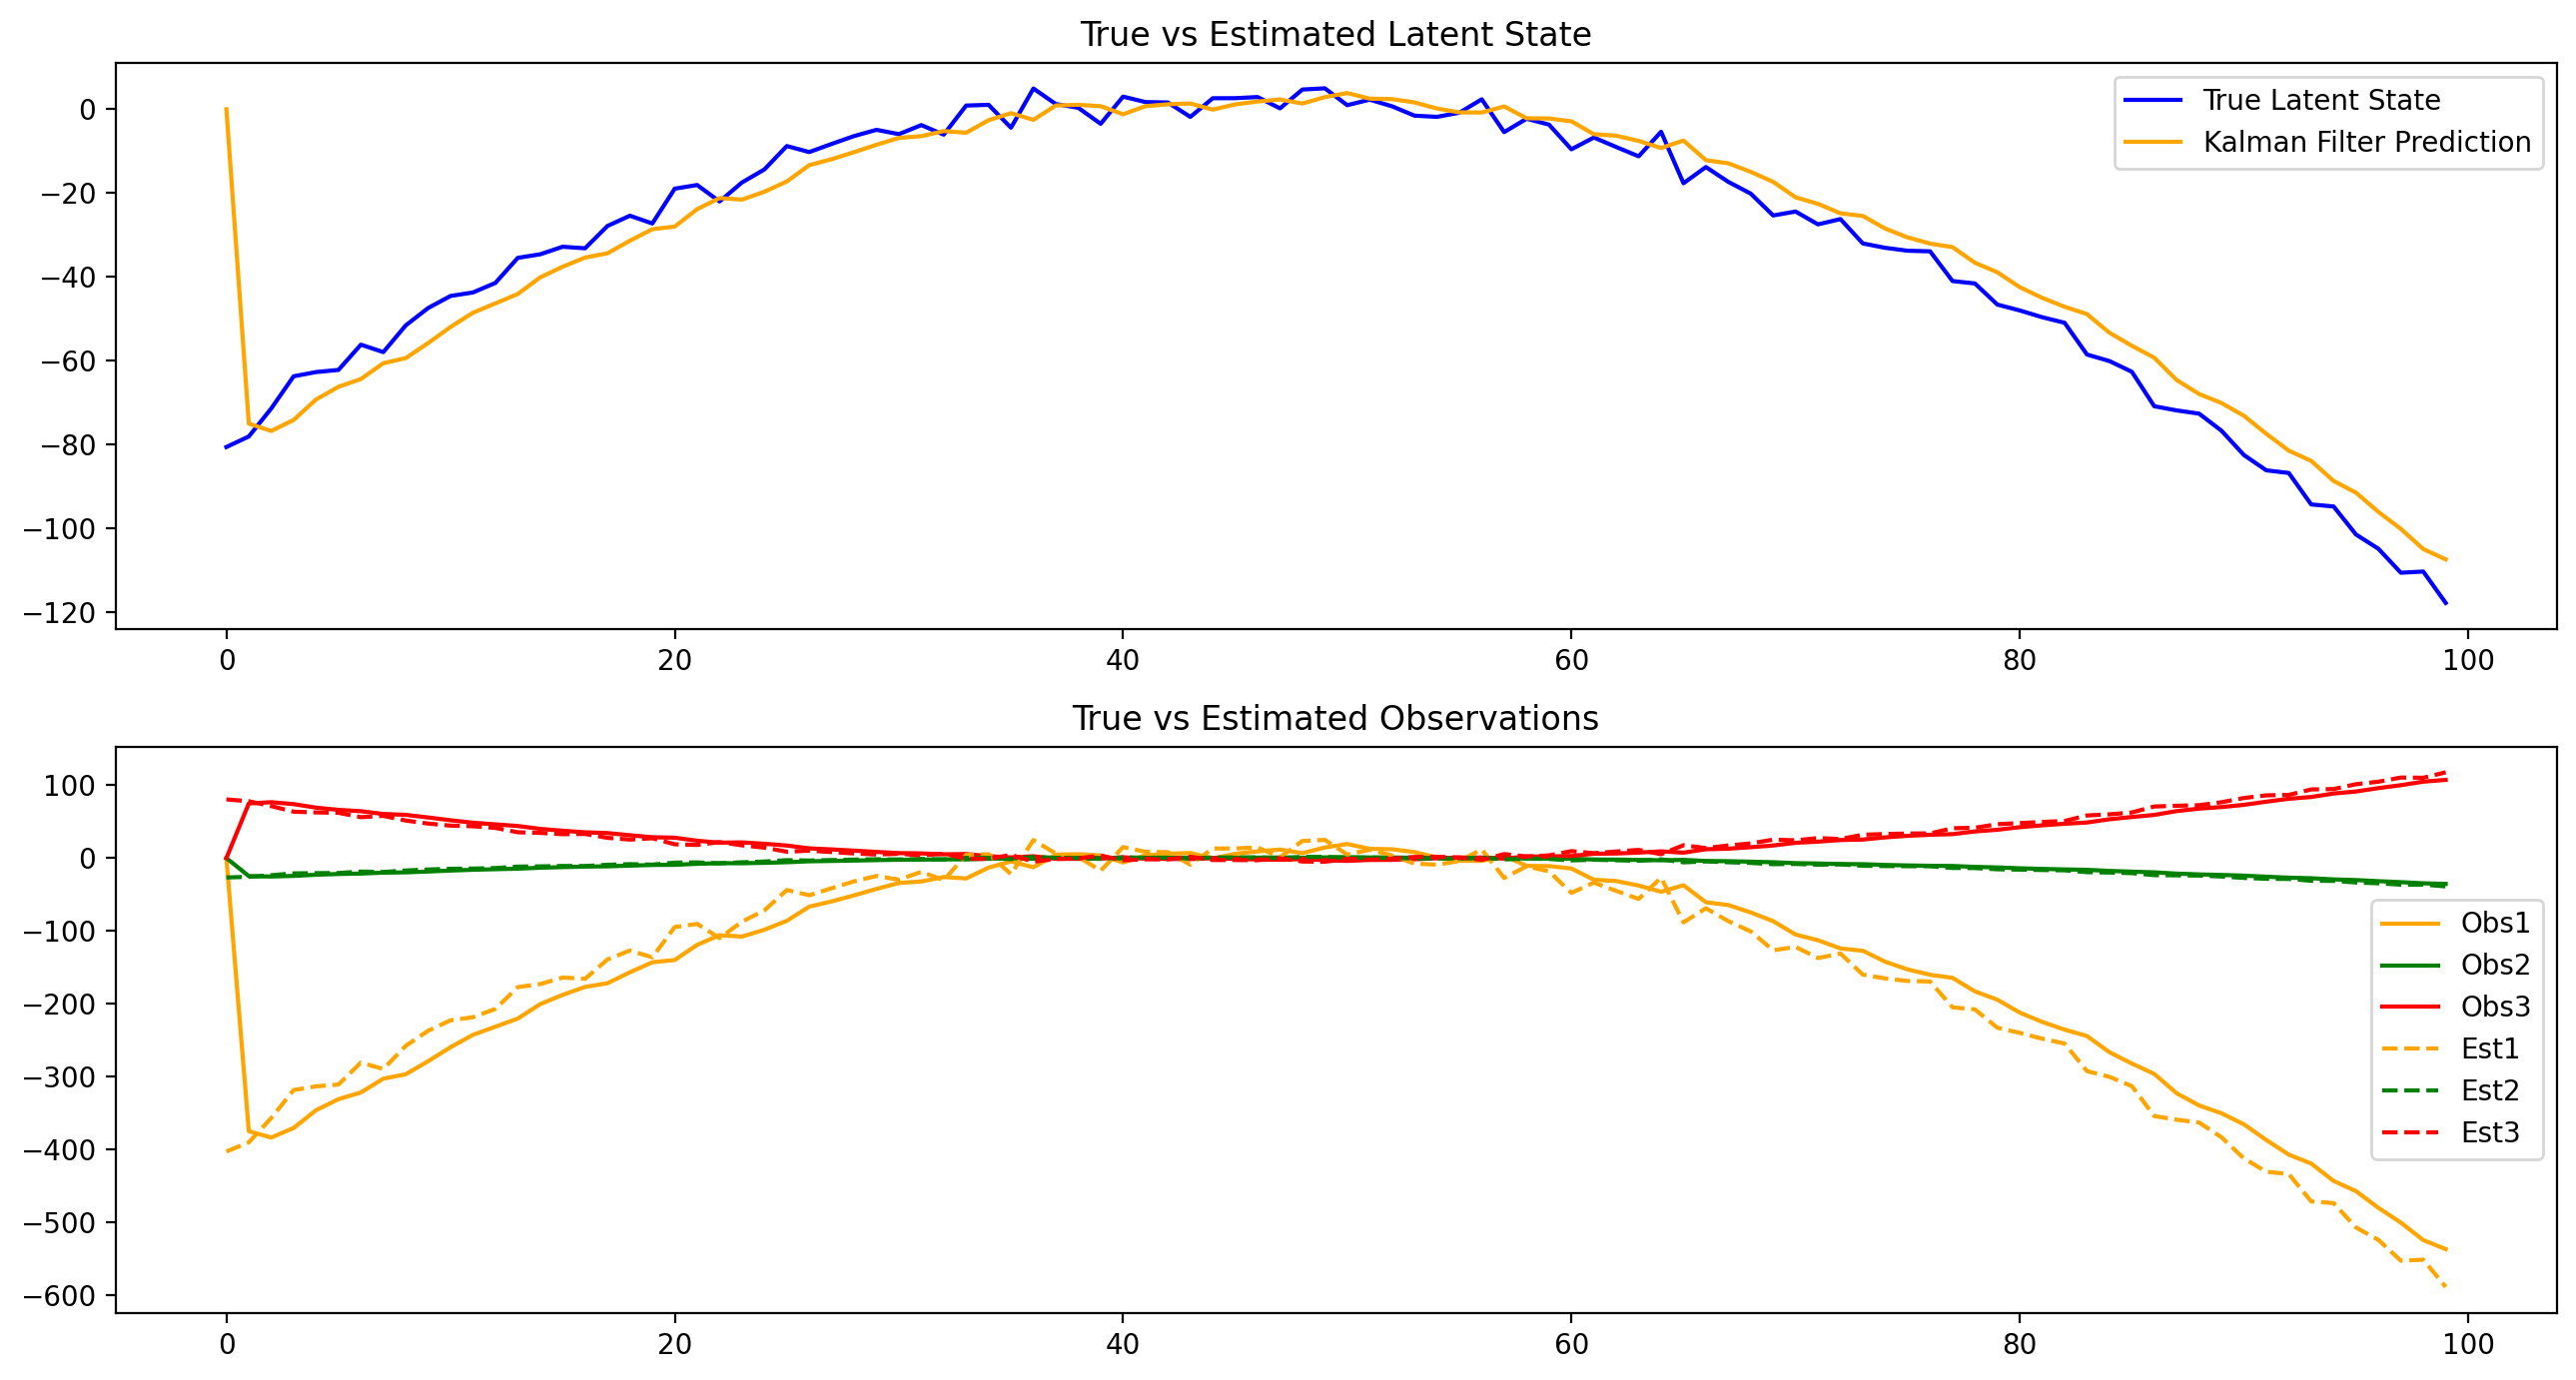

In [226]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state

kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state, prediction_covs, predictions_obs = kf.forward(observations)

# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).flatten(), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Obs{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Est{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


## Another Example

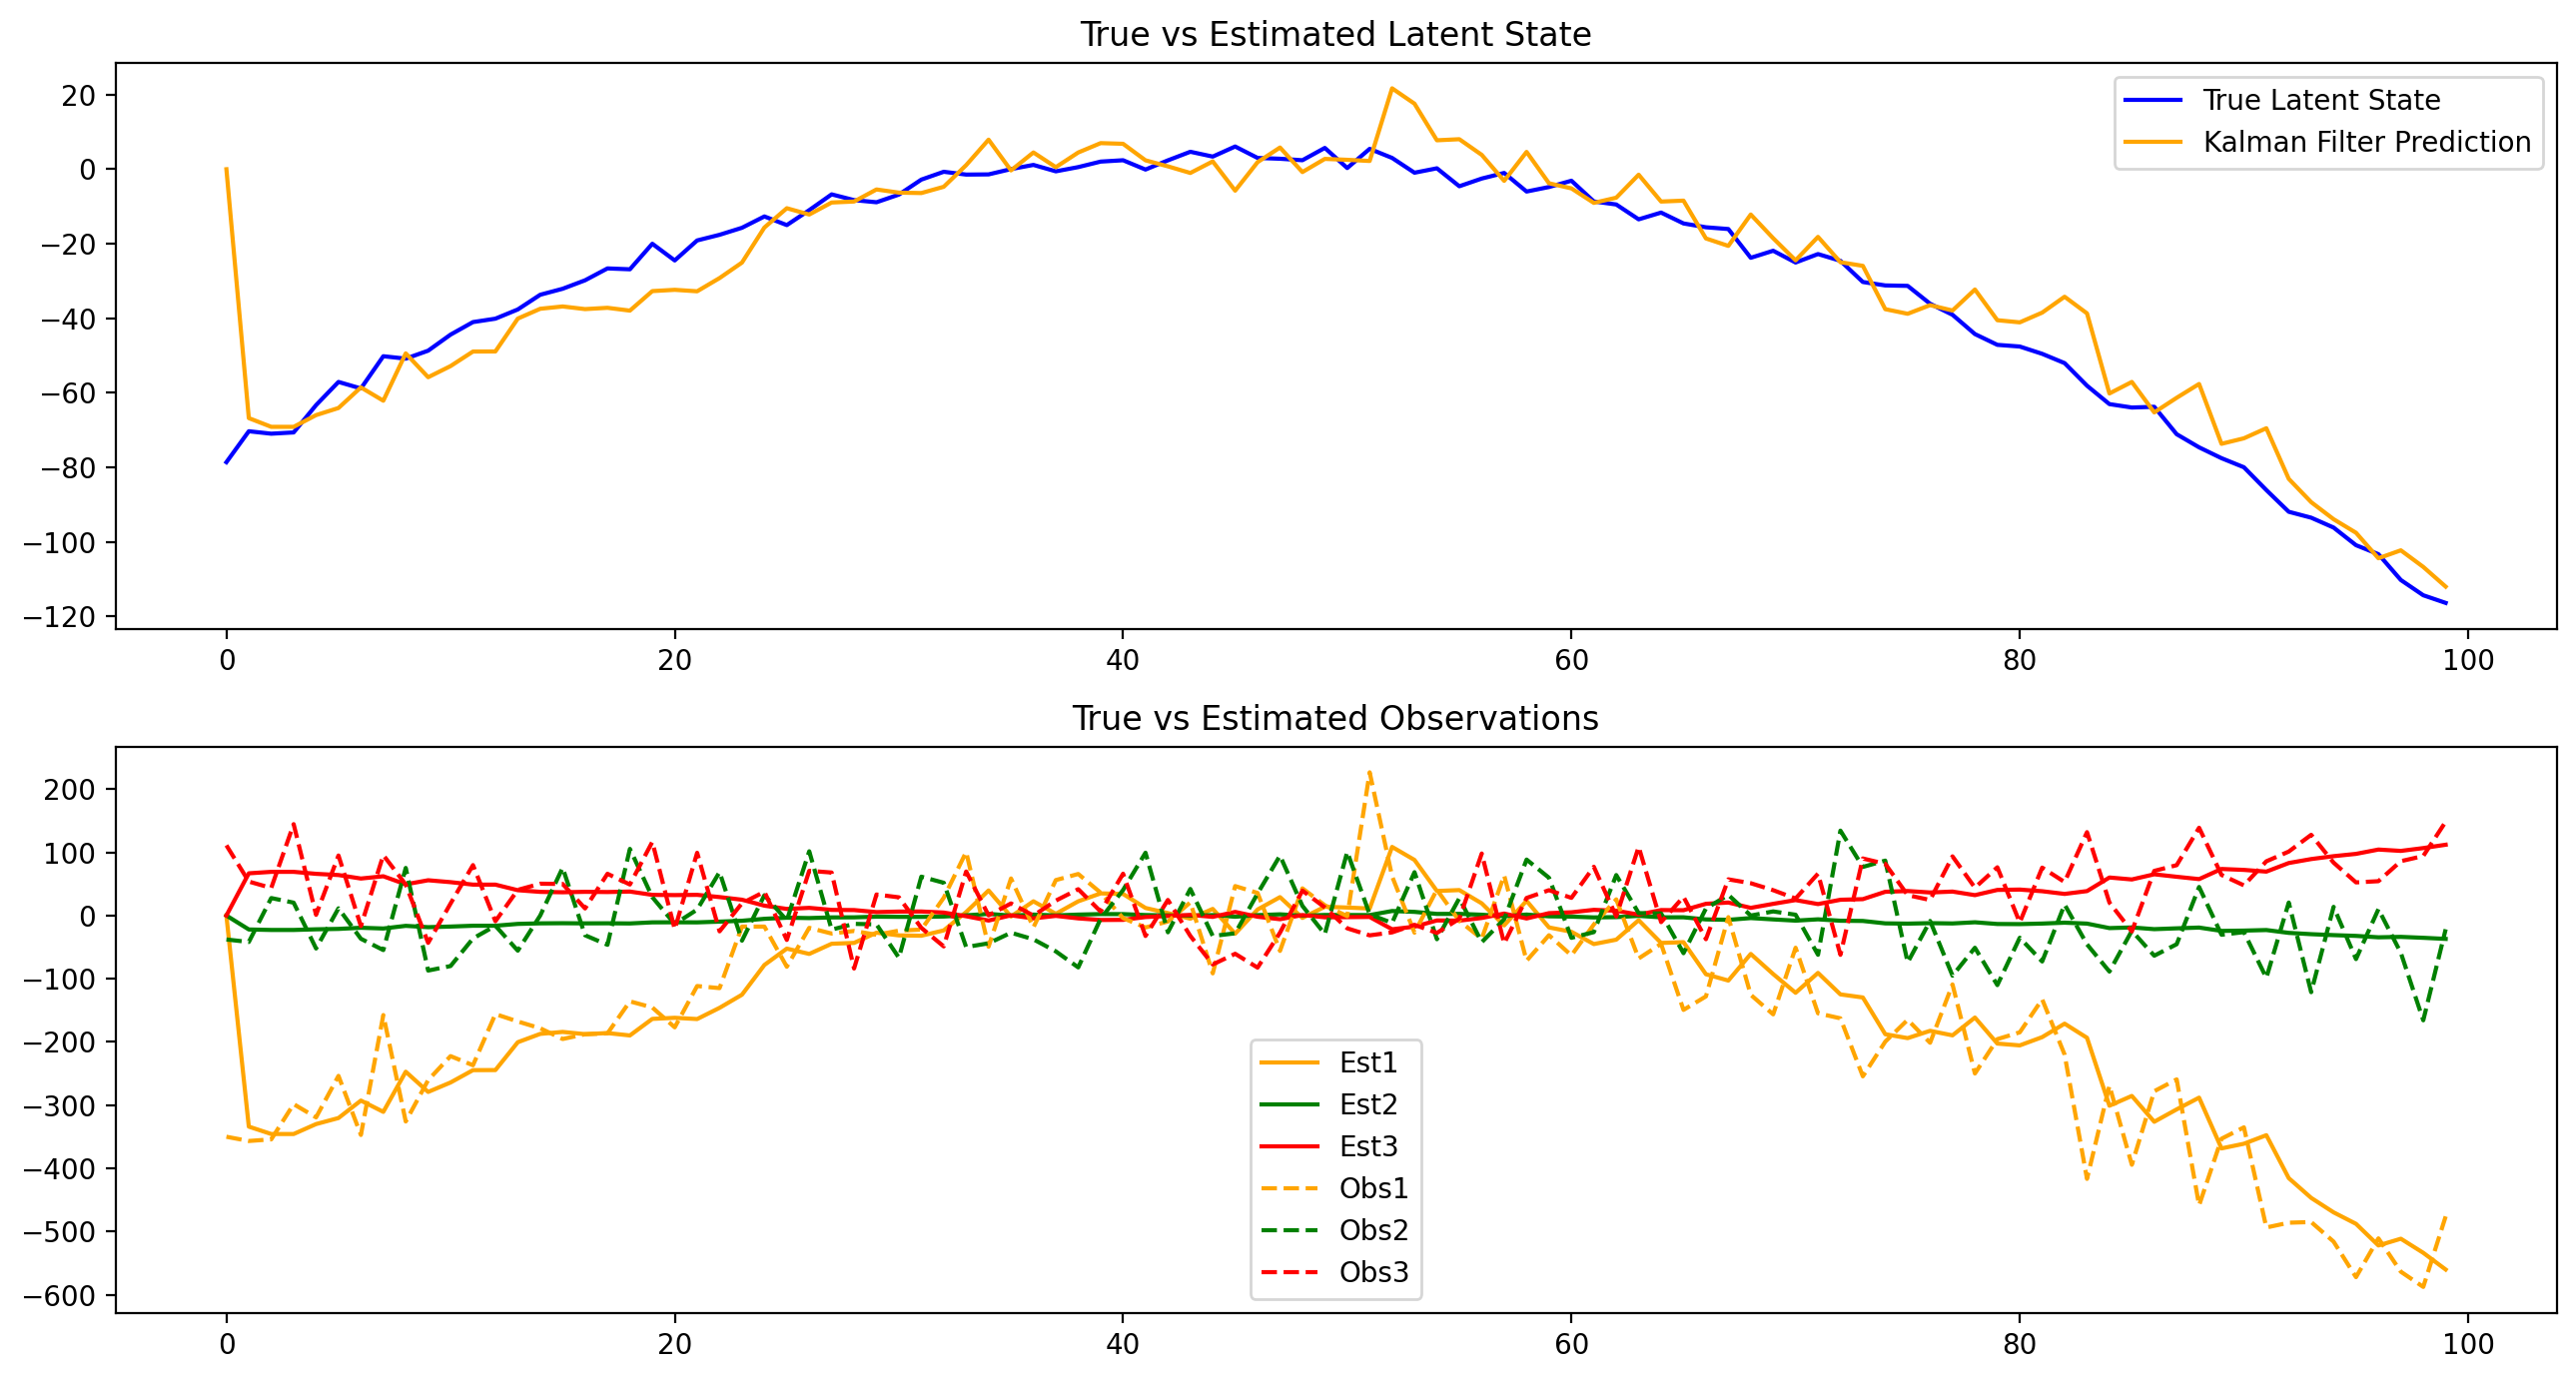

In [227]:
F = np.array([[1]])  # Assuming no change in state

H = np.array([[5],  # First observation directly maps to the state
              [0.33],  # Second observation directly maps to the state
              [-1]]) # Third observation directly maps to the state

Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]]) # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


x = np.linspace(-10, 10, 100)
latent_state = (- (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)).reshape(1,100)
observations = H @ latent_state + np.random.normal(0,50,300).reshape(3,100)



kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state, prediction_covs, predictions_obs = kf.forward(observations)


# Assuming predictions_obs, observations, latent_state, and predictions are defined

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(latent_state.T)), latent_state.T, label='True Latent State', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(100,1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("True vs Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(100, 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()


## KF on real Data

In [228]:
#data preperation
#tx = pd.read_csv("tx_long.csv")
tx = pd.read_csv("./data/data_scales/TX/tx_long.csv")
pivoted = tx.pivot(index='studentID',columns='meas',values=['PANN01_state','PANN05_state','PANN09_state'])

# Should forward fill these I think. Or drop from analysis?
PANN01_state = pivoted['PANN01_state'].T
PANN05_state = pivoted['PANN05_state'].T
PANN09_state = pivoted['PANN09_state'].T



Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
Y = np.transpose(Y,(1,2,0))
Y.shape

# For getting factor loadings we need the dataset filled. 
# Here we interpolate, forwardfill and backfill the remaining values.
# This isn't super clean, but it at least gets it running. Smarter interpolation / calculation of factor loadings can be done later.w
PANN01_state = pivoted['PANN01_state'].interpolate(axis=1).ffill().bfill().T
PANN05_state = pivoted['PANN05_state'].interpolate(axis=1).ffill().bfill().T
PANN09_state = pivoted['PANN09_state'].interpolate(axis=1).ffill().bfill().T
Y1 = PANN01_state.to_numpy()
Y2 = PANN05_state.to_numpy()
Y3 = PANN09_state.to_numpy()
Y_factors = np.stack((Y1,Y2,Y3),axis=2) #axis=0 would lead to (3, 50, 117)
#Y_factors = np.transpose(Y,(1,2,0))
Y_factors.shape


(50, 117, 3)

In [229]:
Y.shape

(117, 3, 50)

#### Factor Loadings

In [230]:
from sklearn.decomposition import FactorAnalysis

In [231]:
transformer = FactorAnalysis(n_components=1, random_state=0)
fit = transformer.fit(Y_factors.reshape(-1,3))
fit.components_.reshape(-1,1)

array([[1.02584791],
       [1.20147747],
       [1.0151294 ]])

In [232]:
H = fit.components_.reshape(-1,1) * 2

In [233]:
H.shape

(3, 1)

#### The rest

Idea: We have a mean and covariance, so we can use the Normal Distribution over the both as a best guess for the missing values. 

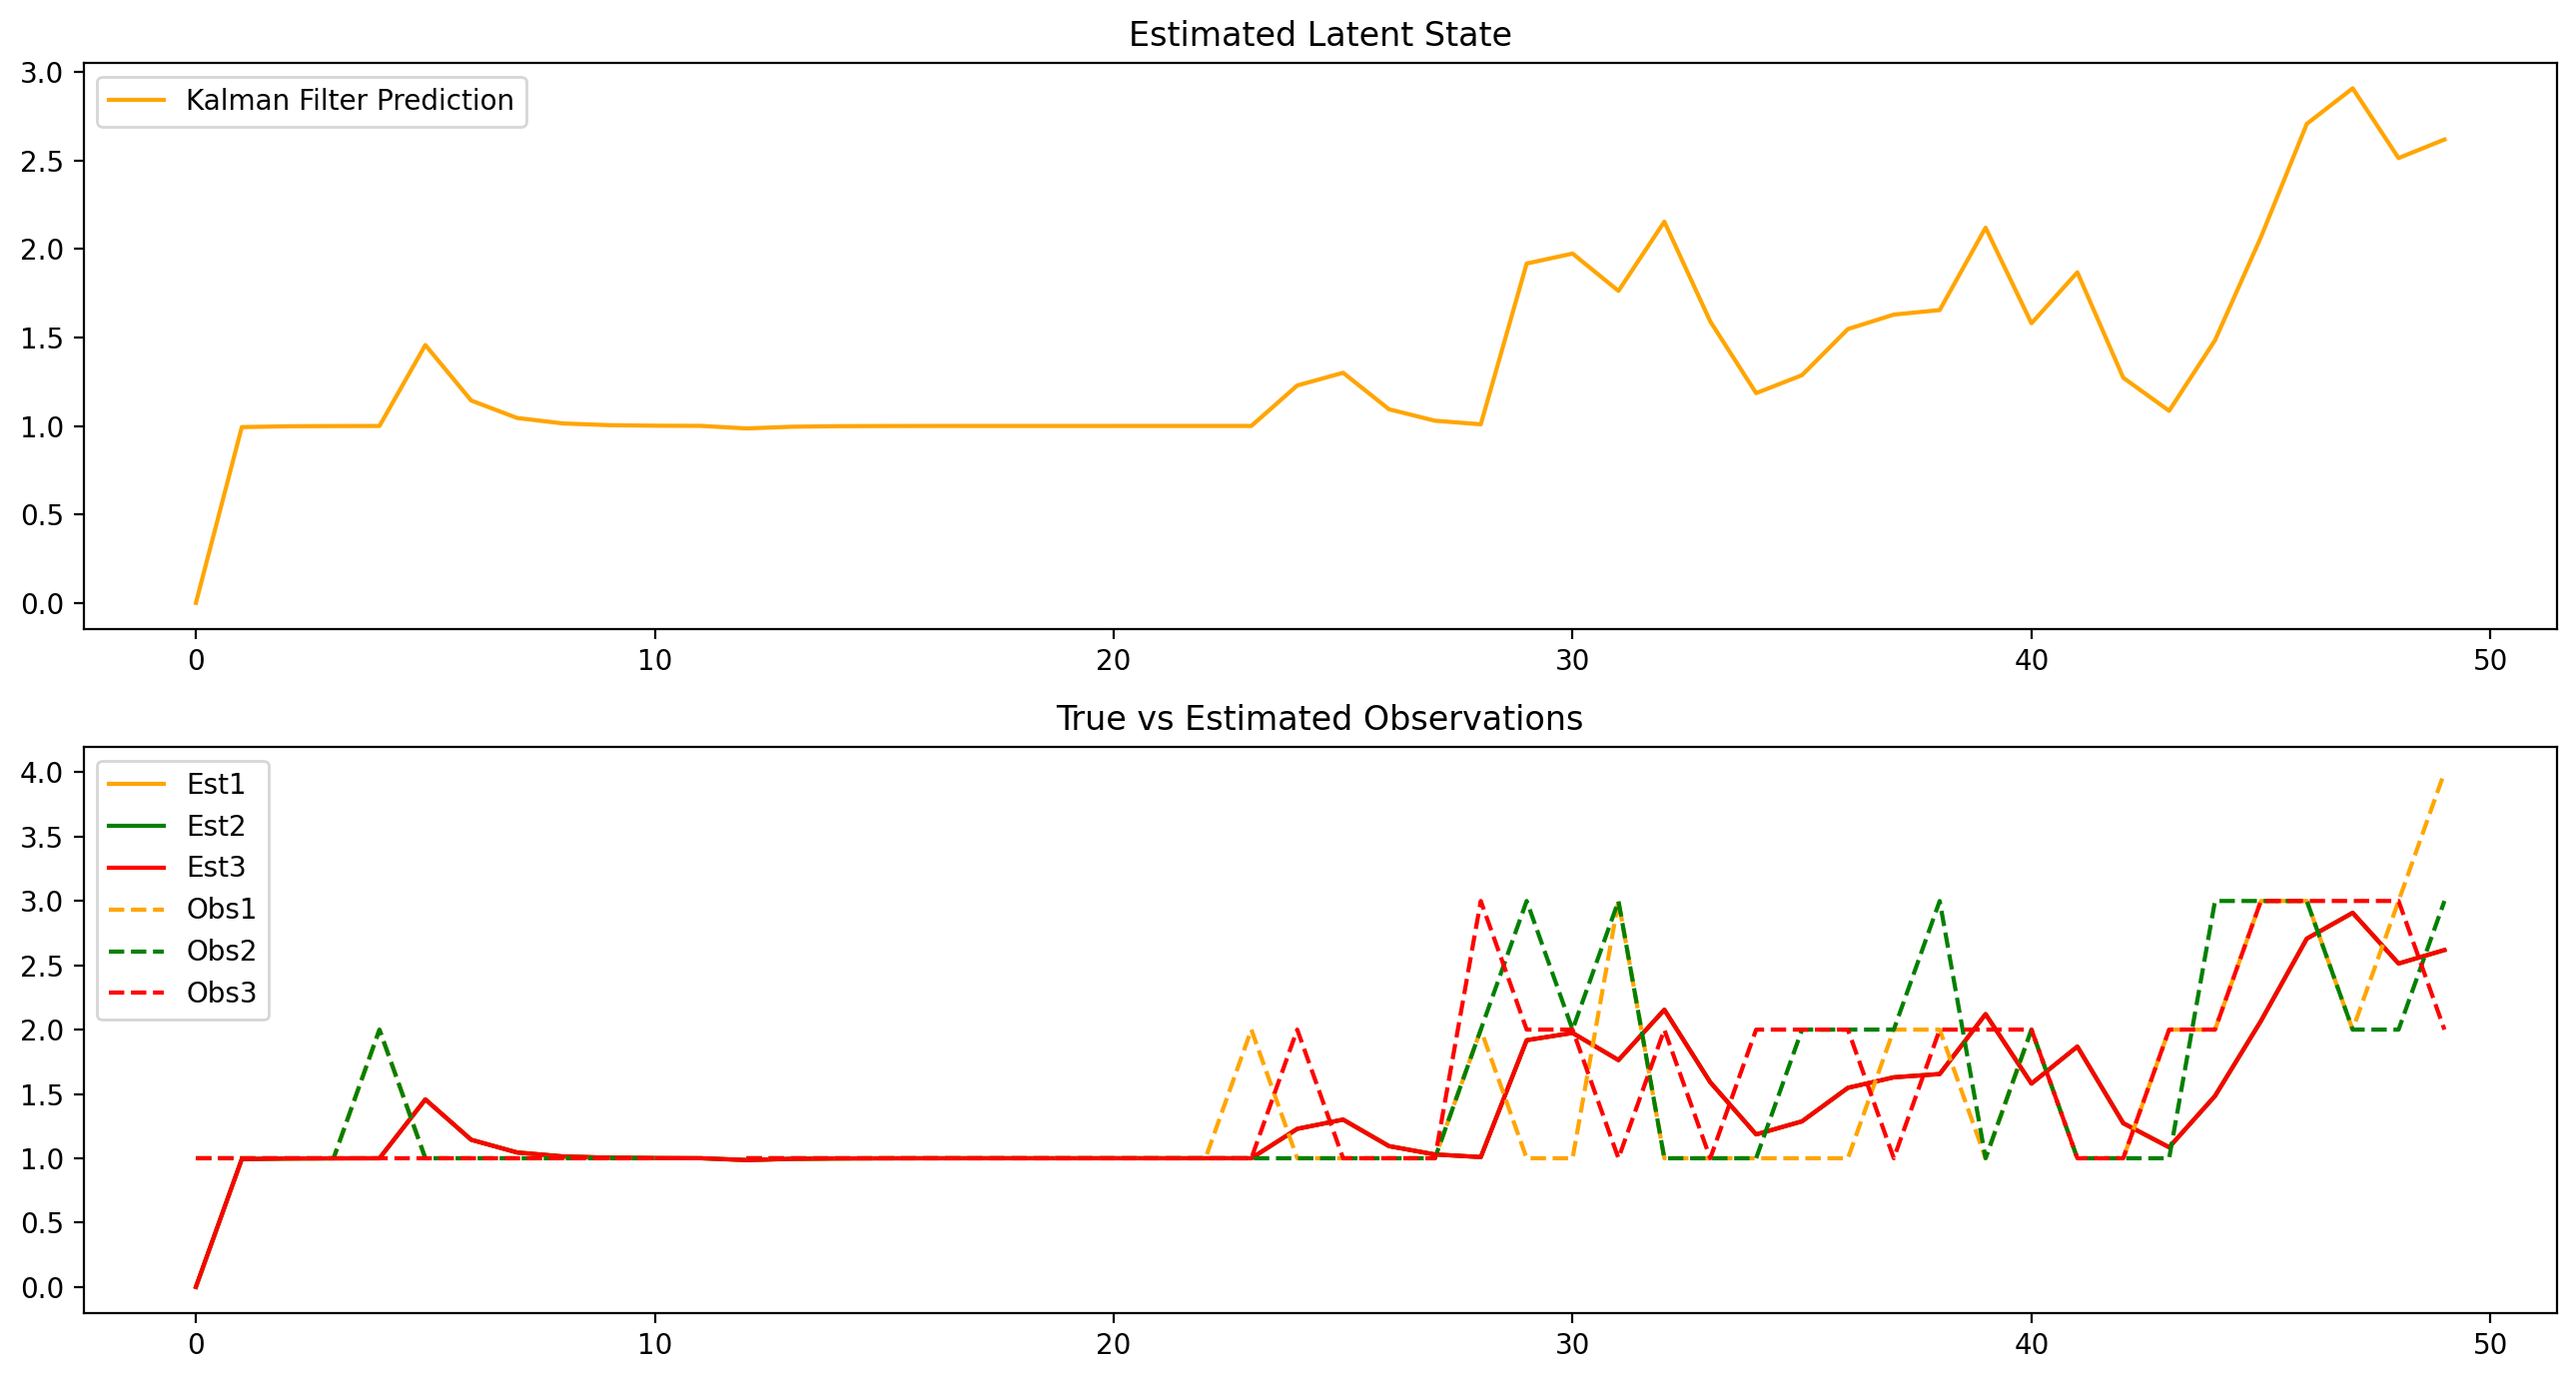

In [252]:
STUDENT = 2

#H = np.array([[1],[1],[1]])
F = np.array([[1]])  # Assuming no change in state


Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.01 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
predictions_state = []
predictions_obs = []
predictions_cov = []

for z in observations:
    z = z.reshape(3,1)
    if np.isnan(z).any():# all the missing values
        if not predictions_state: #if predictions are empty, meaning that the first observation is empty i.e. the first value is nan, set z to 1,1,1
            z = np.array([2,2,2]).reshape(3,1)
        else:
            expected_mean = np.random.normal(predictions_state[-1],predictions_cov[-1]) # sampling from the last observed step
            z = H @ expected_mean #from latent to observed state
    
    predictions_dummy,prediction_dummy_cov = kf.predict()
    predictions_obs.append(H @ predictions_dummy)
    predictions_state.append(predictions_dummy)
    predictions_cov.append(prediction_dummy_cov)
    kf.update(z)


# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the true latent state and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(observations),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(predictions_obs).reshape(len(observations), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[:,i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()

## Smoother (still work in progress)

In [253]:
T = 10
inity = np.array([4,5])
y = np.zeros(T)

y[:len(inity)] = inity
K = np.array([0.4,0.3])

for t in range(T-len(inity)):
    t = t + len(inity)
    idx = list(range(t-len(inity),t))
    print(idx)
    
    y[t] = K @ y[idx]
y

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]
[5, 6]
[6, 7]
[7, 8]


array([4.        , 5.        , 3.1       , 2.93      , 2.119     ,
       1.8077    , 1.38991   , 1.140053  , 0.8979799 , 0.72541517])

In [254]:
def kalman_smoother(state_estimates, state_covariances, A):
    """
    Kalman smoother implementation for refining state estimates.

    Parameters:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    - A: State transition matrix (shape: (1, 1))

    Returns:
    - smoothed_state_estimates: Array of smoothed latent states (shape: (1, T))
    """

    T = state_estimates.shape[1]

    smoothed_state_estimates = np.zeros((1, T))

    # Initialization
    smoothed_state_estimates[:, -1] = state_estimates[:, -1]

    for t in range(T-2, -1, -1):
        # Smoothing step
        smoothed_state_estimates[:, t] = state_estimates[:, t] + \
                                         state_covariances[:, :, t] @ A.T @ \
                                         np.linalg.inv(state_covariances[:, :, t+1]) @ \
                                         (smoothed_state_estimates[:, t+1] - A @ state_estimates[:, t+1])

    return smoothed_state_estimates


First try of the Rauch–Tung–Striebel Smoother (Fixed Step size). As far as I understand it, we call the function every time we get a new observation and smooth all predictions of the latent state backwards. Hence we should do it recursibley over all observations.

There are several types of smoothing filters and the smoother invented by Rauch, Tung, and Striebel is the most efficient one because of its ease of implementation and efficiency of computation. It is also called RTS smoother. ([Reference](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/13-Smoothing.ipynb))  

## smoother on real data

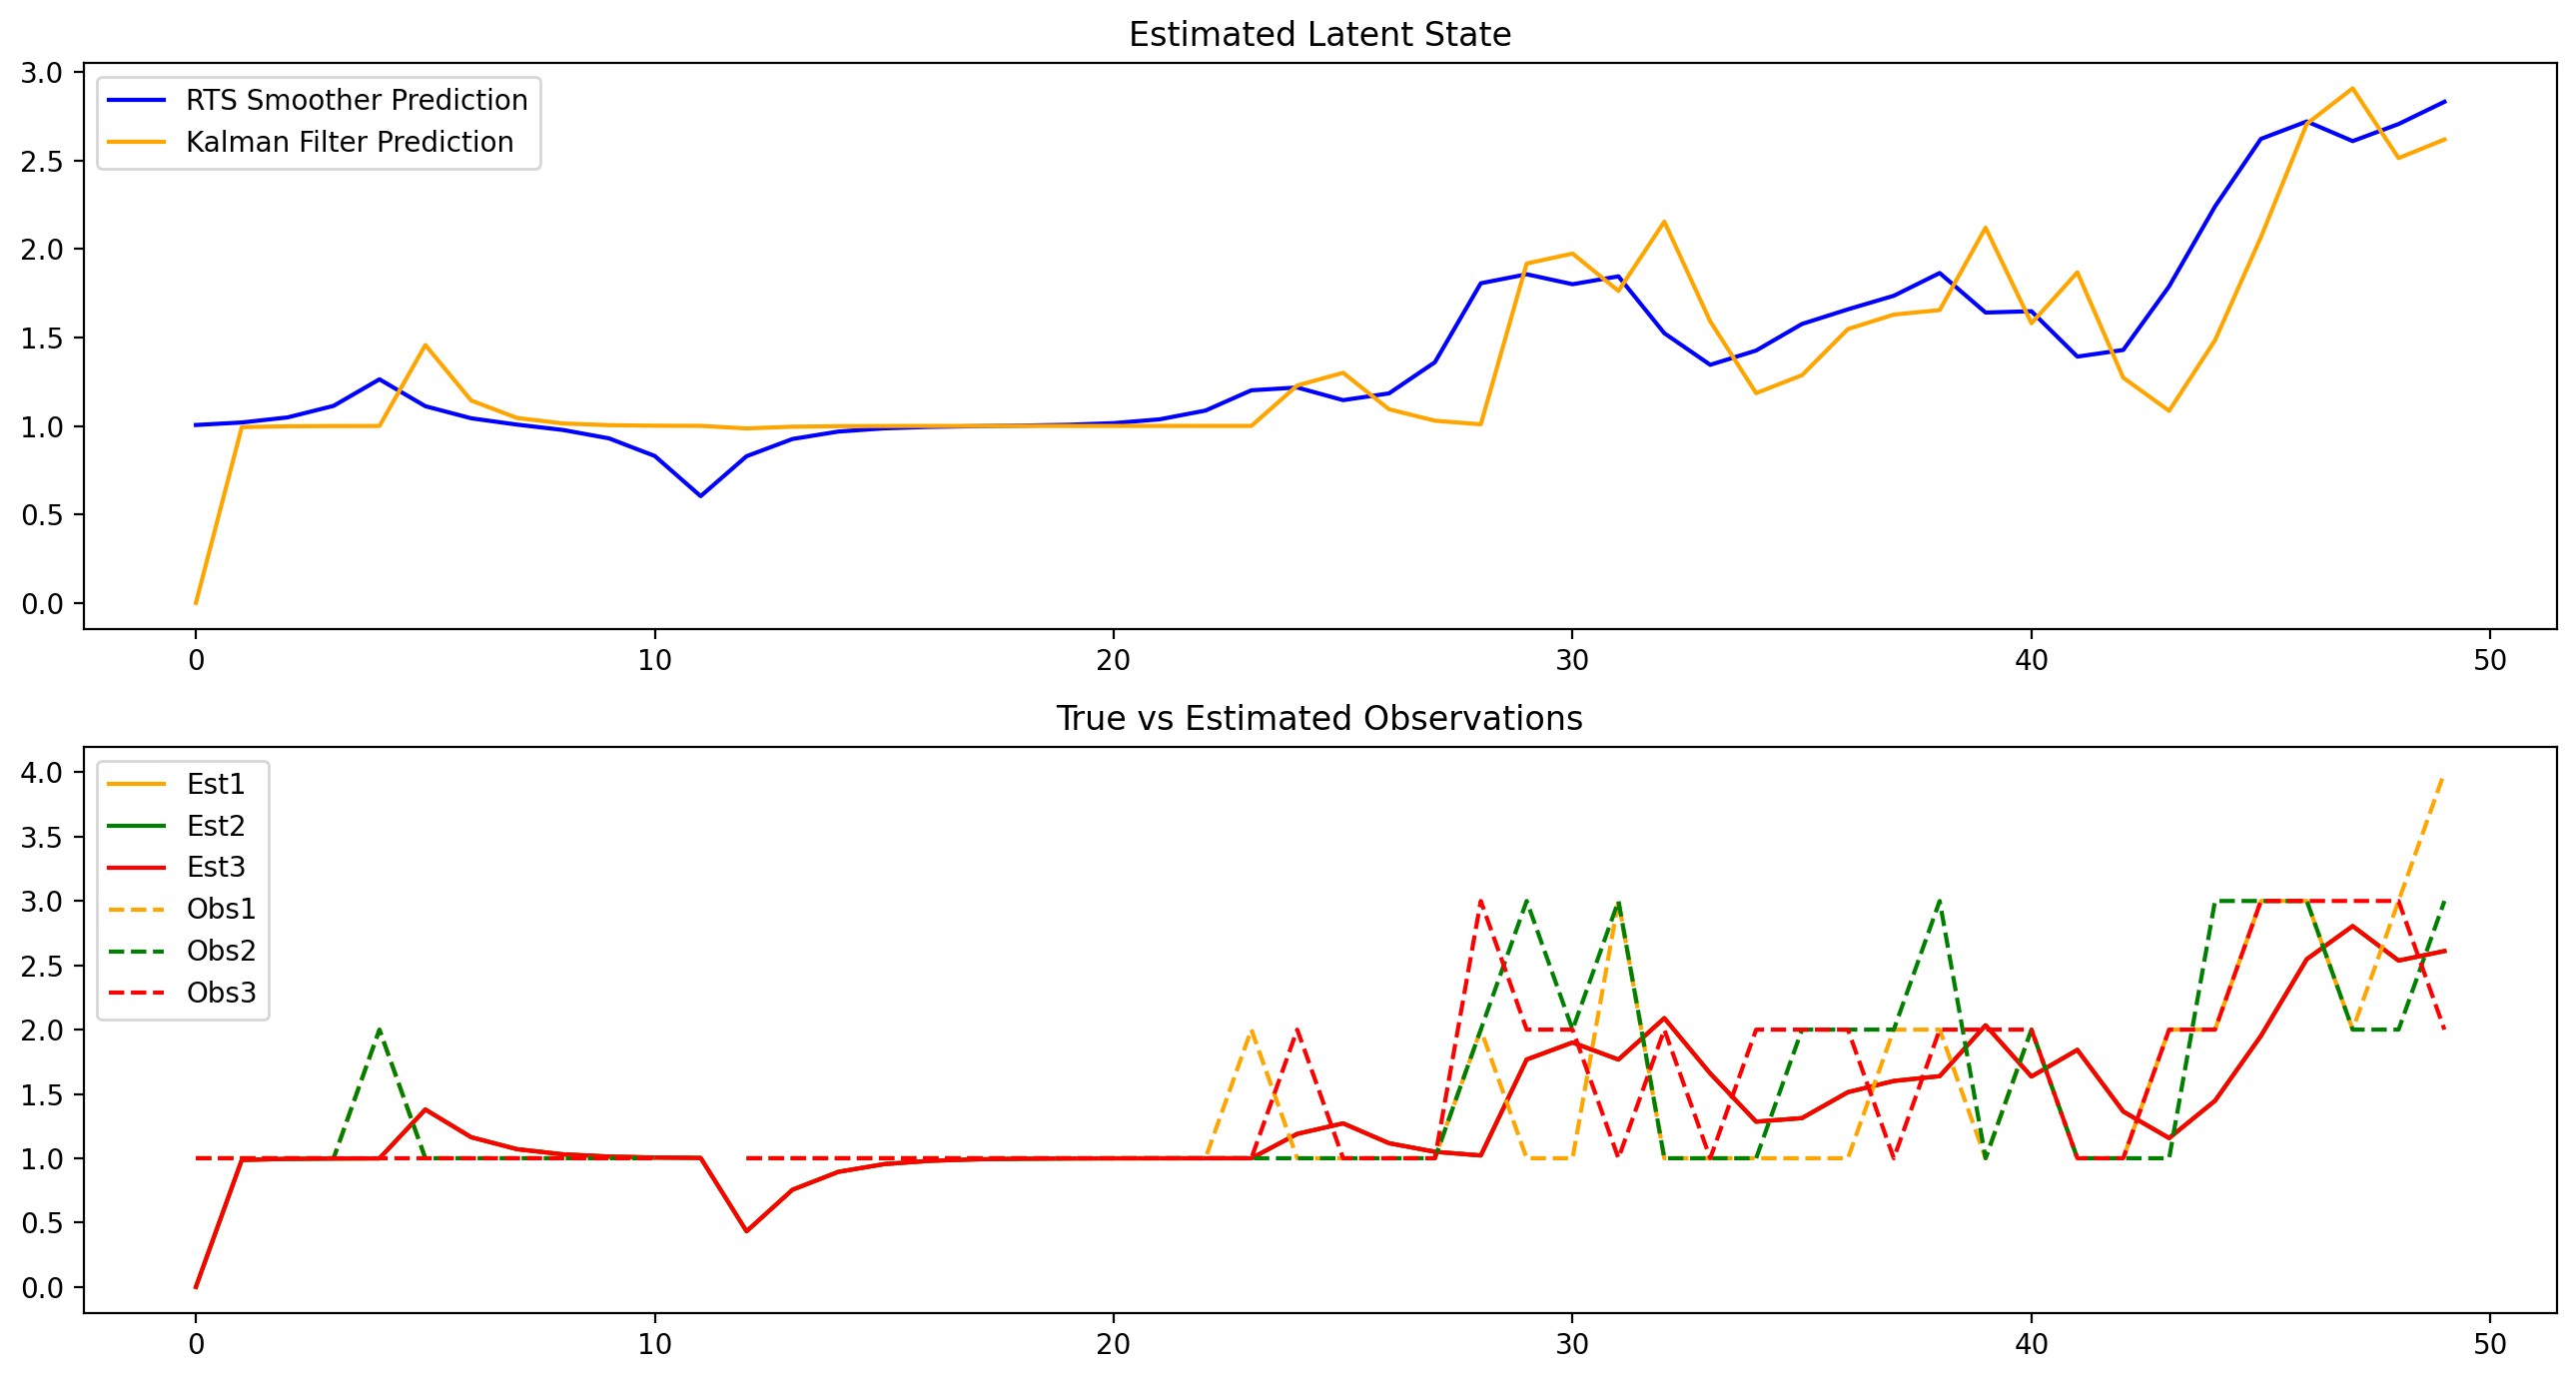

In [255]:
STUDENT = 2

F = np.array([[1]])  # Assuming no change in state


Q = np.array([[0.01]])  # Adjust the value as per your system dynamics and noise characteristics

R = np.array([[2, 0, 0],  # Covariance of the first observation
              [0, 2, 0],  # Covariance of the second observation
              [0, 0, 2]])*0.02 # Covariance of the third observation
x0 = np.array([[0]])  # Initial state estimate


observations = Y[STUDENT,:,:].T


kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)


# Initialize arrays to hold the filtered state estimates and their covariances
n = len(observations)
x_filt = np.zeros((n, kf.n, 1)) # predictions_state
P_filt = np.zeros((n, kf.n, kf.n)) # predictions_cov
obs_filt = [np.zeros((3,1)) for _ in range(50)] # predictions_obs


for i, z in enumerate(observations):
    z = z.reshape(3, 1)

    # If the observation is missing (NaN), impute it
    if np.isnan(z).any():
        if i == 0:  # If the first observation is missing, use an arbitrary value
            z = np.array([[2], [2], [2]])
        else:  
            #z = np.dot(kf.H, x_filt[i-1]) # Otherwise, use the previous state estimate
            expected_mean = np.random.normal(x_filt[-1],P_filt[-1]) # sampling from the last observed step
            z = H @ expected_mean #from latent to observed state

    # Predict the next state
    x_pred, P_pred = kf.predict()
    x_filt[i] = x_pred
    P_filt[i] = P_pred
    obs_filt[i] = H @ x_pred

    # Update the state estimate with the current observation
    kf.update(z)
    x_filt[i] = kf.x
    P_filt[i] = kf.P

# Run the RTS smoother on the filtered estimates and get the smoothed state estimates and their covariances
x_smooth, P_smooth, K = kf.rts_smoother(x_filt, P_filt)

# Create a figure and two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))

# Plotting the smoothed state estimates and Kalman filter predictions on the first subplot (ax1)
ax1.plot(range(len(x_smooth)), x_smooth.reshape(len(observations),1), label='RTS Smoother Prediction', color='blue')
ax1.plot(range(len(predictions_state)), np.array(predictions_state).reshape(len(observations),1), label='Kalman Filter Prediction', color='orange')
ax1.set_title("Estimated Latent State")
ax1.legend()

# Plotting observations and estimates on the second subplot (ax2)
colors = ['orange', 'green', 'red']

# Plotting observations
for i in range(3):
    ax2.plot(np.array(obs_filt).reshape(len(observations), 3)[:, i], label=f"Est{i+1}", color=colors[i])

# Plotting estimates
for i in range(3):
    ax2.plot(observations[:,i], label=f"Obs{i+1}", linestyle="--", color=colors[i])

ax2.legend()
ax2.set_title("True vs Estimated Observations")
# Adjusting layout to prevent overlapping
plt.tight_layout()

plt.show()





## Learning Drop out

Here we will learn a model that predicts drop out from the latent state. 

We will start by using logistic regression, assuming no time dependence. 

For each student, we need the state, and a variable of drop out prediction. From here, to keep the dataset balanced, we will take all drop outs (43 Students), and take the first drop out event of each:

This is a Series of students with their final drop out status:

In [288]:
tx["student_droppedout"] = [ tx[tx.studentID == studentid]["event"].max() for studentid in tx.studentID]

students_with_dropout_status = tx.groupby("studentID")["student_droppedout"].max()
students_with_dropout_status.head()

dropout_students_idx = students_with_dropout_status==1

Here we should that students that dropped out, typically have higher responses to the PANN items:

In [257]:
tx.groupby("student_droppedout")[['PANN01_state','PANN05_state','PANN09_state']].mean()

,PANN01_state,PANN05_state,PANN09_state
student_droppedout,,,
0,2.221820,2.002410,2.197954
1,2.585196,2.573816,2.785216


#### Calculate states for each student:

In [258]:
#Y[STUDENT,:,:].T
n_students = Y.shape[0]
n_time = Y.shape[2]


states = np.zeros((n_students, n_time, 1,1))
covs = np.zeros((n_students, n_time, 1,1))


for i in range(n_students):

    observations = Y[i,:,:].T
    
    
    kf = KalmanFilter(F = F, H = H, Q = Q, R = R, x0 = x0)
    predictions_state = []
    predictions_obs = []
    predictions_cov = []
    
    for z in observations:
        z = z.reshape(3,1)
        if np.isnan(z).any():# all the missing values
            if not predictions_state: #if predictions are empty, meaning that the first observation is empty i.e. the first value is nan, set z to 1,1,1
                z = np.array([2,2,2]).reshape(3,1)
            else:
                expected_mean = np.random.normal(predictions_state[-1],predictions_cov[-1]) # sampling from the last observed step
                z = H @ expected_mean #from latent to observed state
        
        predictions_dummy,prediction_dummy_cov = kf.predict()
        predictions_obs.append(H @ predictions_dummy)
        predictions_state.append(predictions_dummy)
        predictions_cov.append(prediction_dummy_cov)
        kf.update(z)

    states[i] = np.array(predictions_state)
    covs[i] = np.array(predictions_cov)

states = states.reshape(117,50)

In [291]:
print(f"Mean State for dropout Students {states[dropout_students_idx].mean()}")
print(f"Mean State for non-dropout Students {states[~dropout_students_idx].mean()}")

Mean State for dropout Students 2.442702102046333
Mean State for non-dropout Students 1.9780562985479635


This also shows us that, for the most part, the state estimates for dropout students are also higher than those for non-dropout students. This means, we should be able to get sort of dropout estimate from the state data...


---

Let us start by predicting final dropout, based on the sum of the state variable.

That is, we don't try to predict WHEN a student will drop out, but rather whether or not the student will finish.

We can try this by simple logistic regression, with the average state as an input at time t.

Let us first check the balance of the data. Because we are using logistic regression, we need to work with balanced data, otherwise the estimator will just predict the highest occuring class for to get the best performance.

In [292]:
print(f"Percentage of Students that dropped out: {students_with_dropout_status.mean().round(3)*100}%")

Percentage of Students that dropped out: 36.8%


Let us first split the `states` matrix, into 2. One for students that dropped out, and one for students that didn't. This allows us to randomly and safely sample from the non-dropout students to create a balanced dataset.

In [295]:
states_dropouts = states[dropout_students_idx]
states_non_dropouts = states[~dropout_students_idx]

print(f"Shape of states array for dropout students: {states_dropouts.shape}")
print(f"Shape of states array for non-dropout students: {states_non_dropouts.shape}")

Shape of states array for dropout students: (43, 50)
Shape of states array for non-dropout students: (74, 50)


Now, we write a function that will create a random (w.r.t. the non-dropout students) dataset. We can use this later for testing and validation

In [390]:
def create_dataset(intercept=True):
    n_drop = states_dropouts.shape[0]
    # 1 and 0 vector of length 43 + 43
    y = np.array([1] * n_drop + [0] * n_drop)

    X_dropouts  = states_dropouts.mean(axis=1)
    idx_stayers = np.random.choice(list(range(len(states_dropouts))),n_drop) 
    X_stayers   = states_non_dropouts[idx_stayers].mean(axis=1)
    # Stack the Xs to create 1 array
    X = np.concatenate([X_dropouts,X_stayers])
    # Add an intercept
    if intercept:
        X = np.vstack([np.ones_like(X),X]).T
    return X, y

In [391]:
X, y = create_dataset()
X.shape

(86, 2)

Check to see whether the X data still has a decent amount of difference between the 2 classes

In [393]:
print(f"Non-dropout State Mean: {X[43:,1].mean()}")
print(f"Dropout State Mean: {X[:43,1].mean()}")

Non-dropout State Mean: 2.2921310240116655
Dropout State Mean: 2.442702102046333


From here, we want to train a basic logistic regression classifier that we can then attach to the output of the kalman filter estimates in order to predict the dropout

In [394]:
from statsmodels.discrete.discrete_model import Logit

In [395]:
log_model = Logit(y,X)
log_res = log_model.fit()
log_res.summary()

Optimization terminated successfully.
         Current function value: 0.689731
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:                          Logit   Df Residuals:                       84
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Mar 2024   Pseudo R-squ.:                0.004929
Time:                        09:44:23   Log-Likelihood:                -59.317
converged:                       True   LL-Null:                       -59.611
Covariance Type:            nonrobust   LLR p-value:                    0.4433
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4307      0.604     -0.713      0.476      -1.614       0.753
x1             0.1820      0.238      0.764      0.445      -0.285       0.649
==============================================================================
"""

In [403]:
predicted_ys = log_res.predict(X)
predicted_ys
pd.crosstab(predicted_ys>0.5,y)

col_0,0,1
row_0,,
False,24,20
True,19,23


Performance isn't optimal

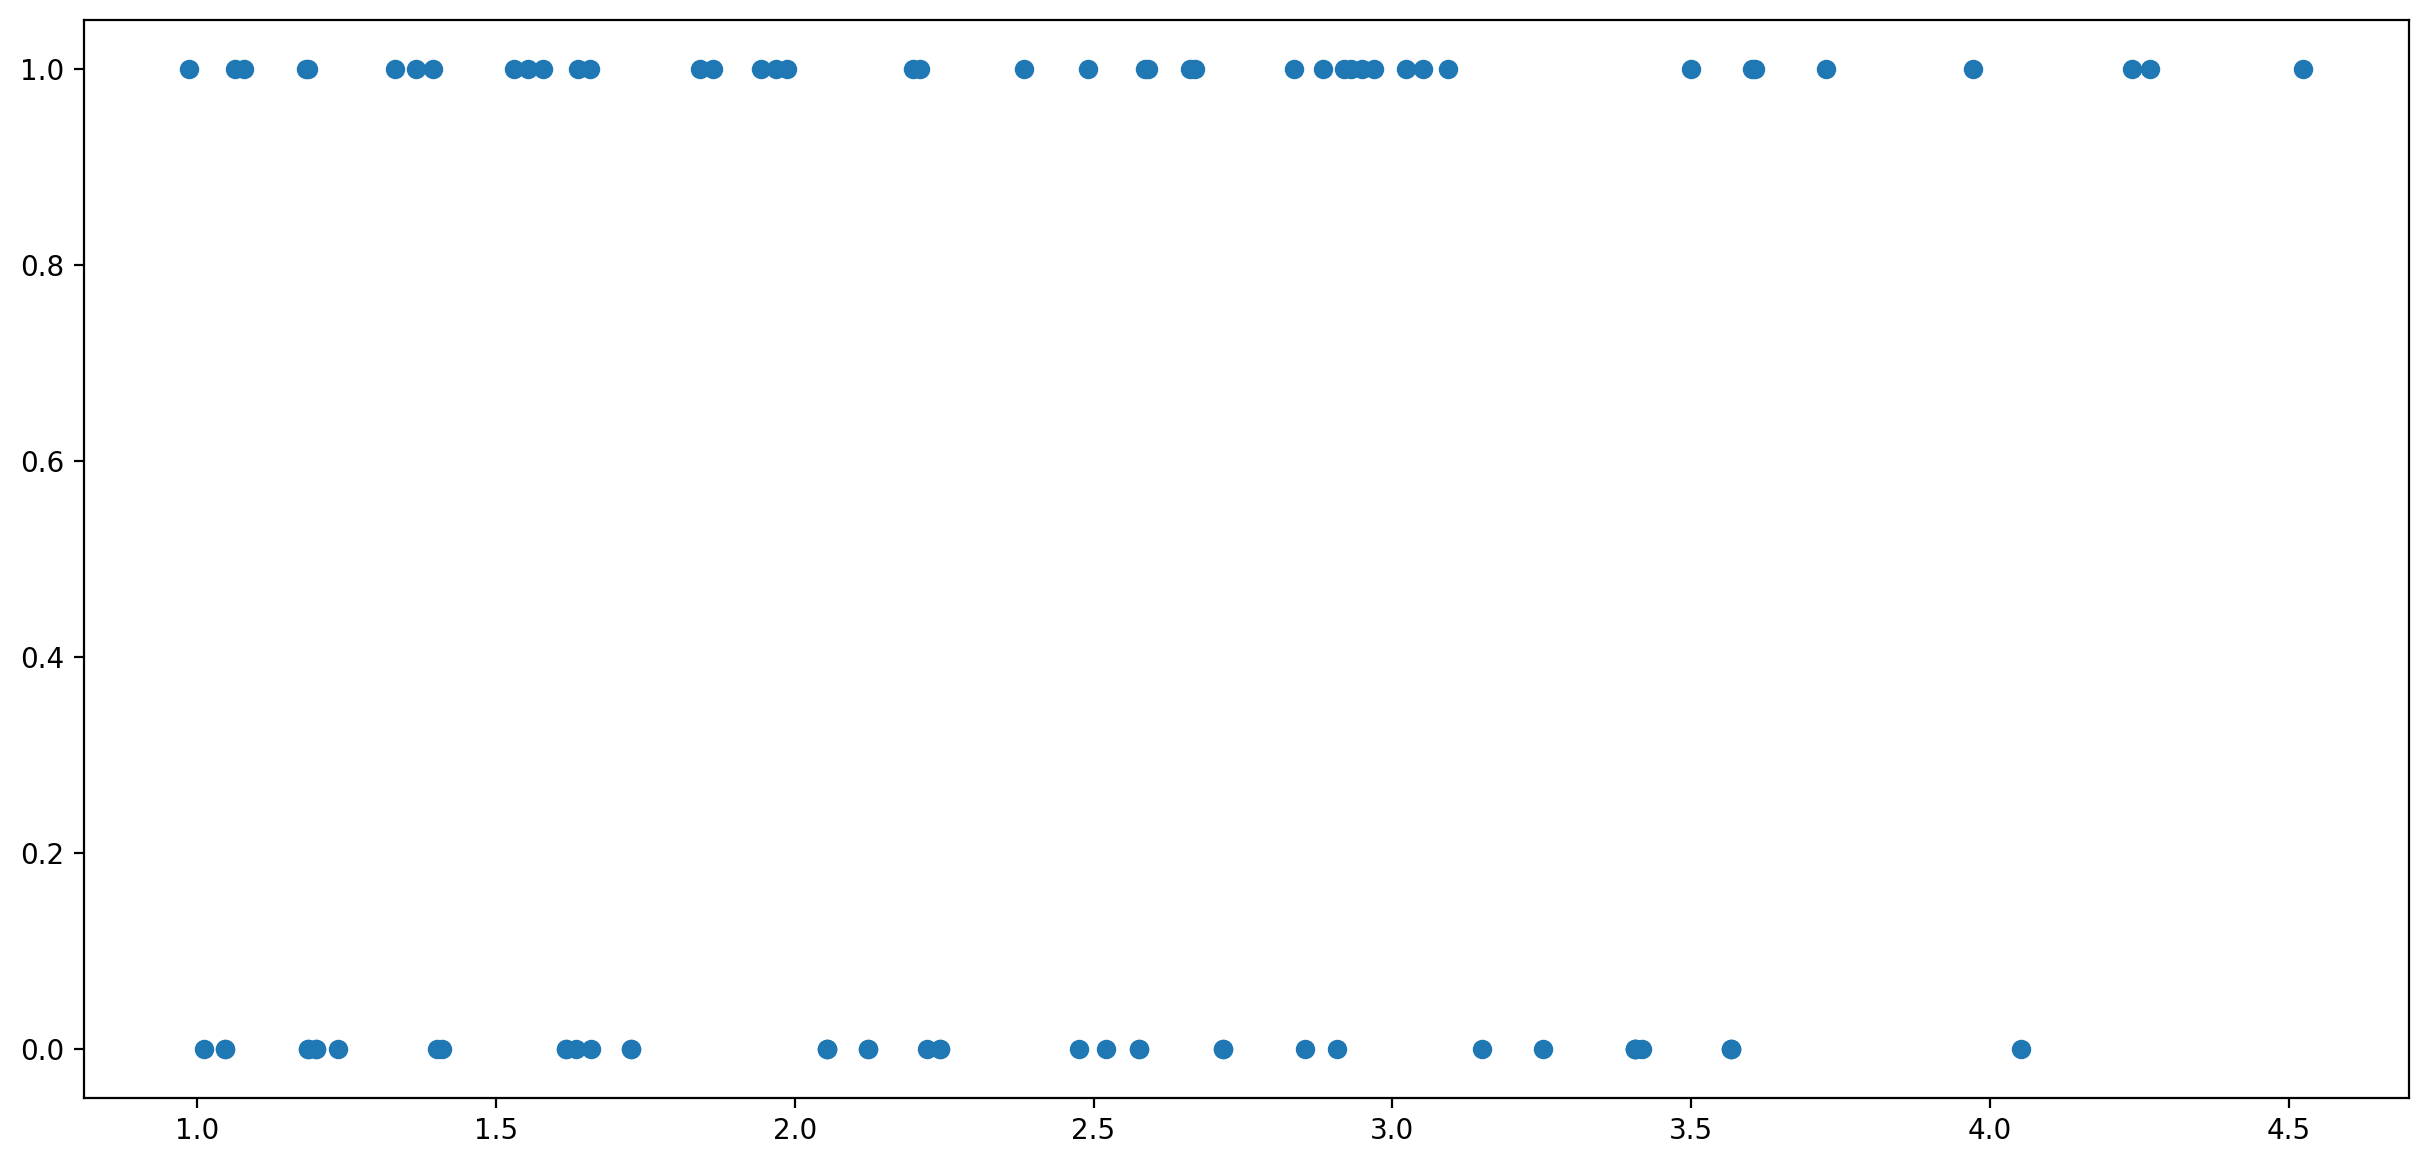

In [404]:
plt.scatter(X[:,1],y)